# 04 - Relationships and Correlations

This notebook focuses on analyzing relationships and correlations between features and the target variable (price) in the enriched FIPE datasets. We'll examine:
- Correlation matrix for numerical features
- Price vs. age relationship
- Price vs. mileage relationship
- Price vs. brand/model analysis
- Price vs. location (state) analysis
- Feature interactions and combinations

## Datasets
- `fipe_cars_enriched.csv`: Historical FIPE data (~599k records)
- `fipe_2022_enriched.csv`: 2022 FIPE data subset (~290k records)


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

# Add src to path to import our modules
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / "src"))

from data.loader import DatasetLoader

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Imports completed successfully")


✅ Imports completed successfully


## 1. Load Datasets


In [ ]:
# Initialize loader
loader = DatasetLoader()

# Load both datasets
df_cars, df_2022 = loader.load_all()

print("\n" + "="*60)
print("Datasets loaded successfully!")
print("="*60)


Loading /app/data/processed/fipe_cars_enriched.csv...
Loaded 599,007 rows and 16 columns
Loading /app/data/processed/fipe_2022_enriched.csv...
Loaded 290,275 rows and 16 columns

Datasets loaded successfully!


## 2. Correlation Matrix (Numerical Features)

We'll analyze correlations between all numerical features, including the target variable (price).


In [ ]:
# Select numerical columns
numerical_cols = df_cars.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns for correlation analysis:")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

# Calculate correlation matrix
correlation_matrix = df_cars[numerical_cols].corr()

print("\n" + "="*60)
print("Correlation Matrix")
print("="*60)
print(correlation_matrix.round(3))


Numerical columns for correlation analysis:
  1. year
  2. price
  3. km
  4. engine_size
  5. doors
  6. age_years
  7. year_of_reference

Correlation Matrix
                   year  price    km  engine_size  doors  age_years  \
year               1.00   0.31 -0.95        -0.12   0.00      -1.00   
price              0.31   1.00 -0.30         0.35  -0.00      -0.30   
km                -0.95  -0.30  1.00         0.08  -0.00       0.95   
engine_size       -0.12   0.35  0.08         1.00   0.00       0.12   
doors              0.00  -0.00 -0.00         0.00   1.00      -0.00   
age_years         -1.00  -0.30  0.95         0.12  -0.00       1.00   
year_of_reference  0.02   0.04  0.03        -0.00   0.00       0.04   

                   year_of_reference  
year                            0.02  
price                           0.04  
km                              0.03  
engine_size                    -0.00  
doors                           0.00  
age_years                       0.04  

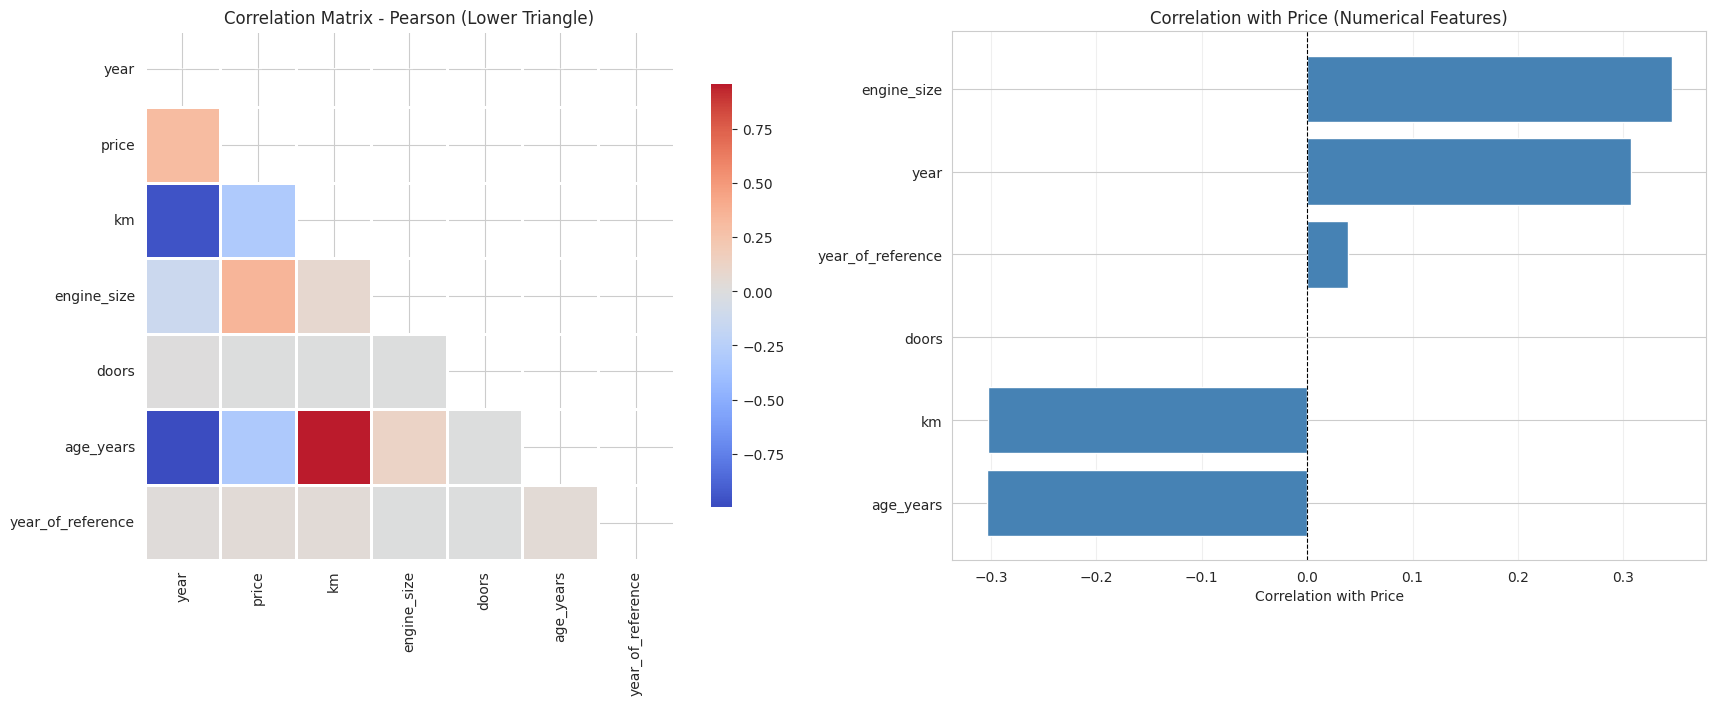


Correlations with Price (sorted by absolute value):
------------------------------------------------------------
engine_size            0.346
year                   0.307
year_of_reference      0.039
doors                 -0.001
km                    -0.303
age_years             -0.304


In [ ]:
# Visualize correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap with Pearson correlation
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, ax=axes[0])
axes[0].set_title('Correlation Matrix - Pearson (Lower Triangle)', fontsize=12)

# Focus on correlations with price
price_correlations = correlation_matrix['price'].sort_values(ascending=False)
price_correlations = price_correlations[price_correlations.index != 'price']  # Remove self-correlation

axes[1].barh(range(len(price_correlations)), price_correlations.values, color='steelblue')
axes[1].set_yticks(range(len(price_correlations)))
axes[1].set_yticklabels(price_correlations.index)
axes[1].set_xlabel('Correlation with Price')
axes[1].set_title('Correlation with Price (Numerical Features)')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nCorrelations with Price (sorted by absolute value):")
print("-" * 60)
for feature, corr in price_correlations.items():
    print(f"{feature:20s} {corr:7.3f}")


### 2.1 Spearman Correlation (Non-linear Relationships)

Spearman correlation can capture non-linear monotonic relationships better than Pearson.


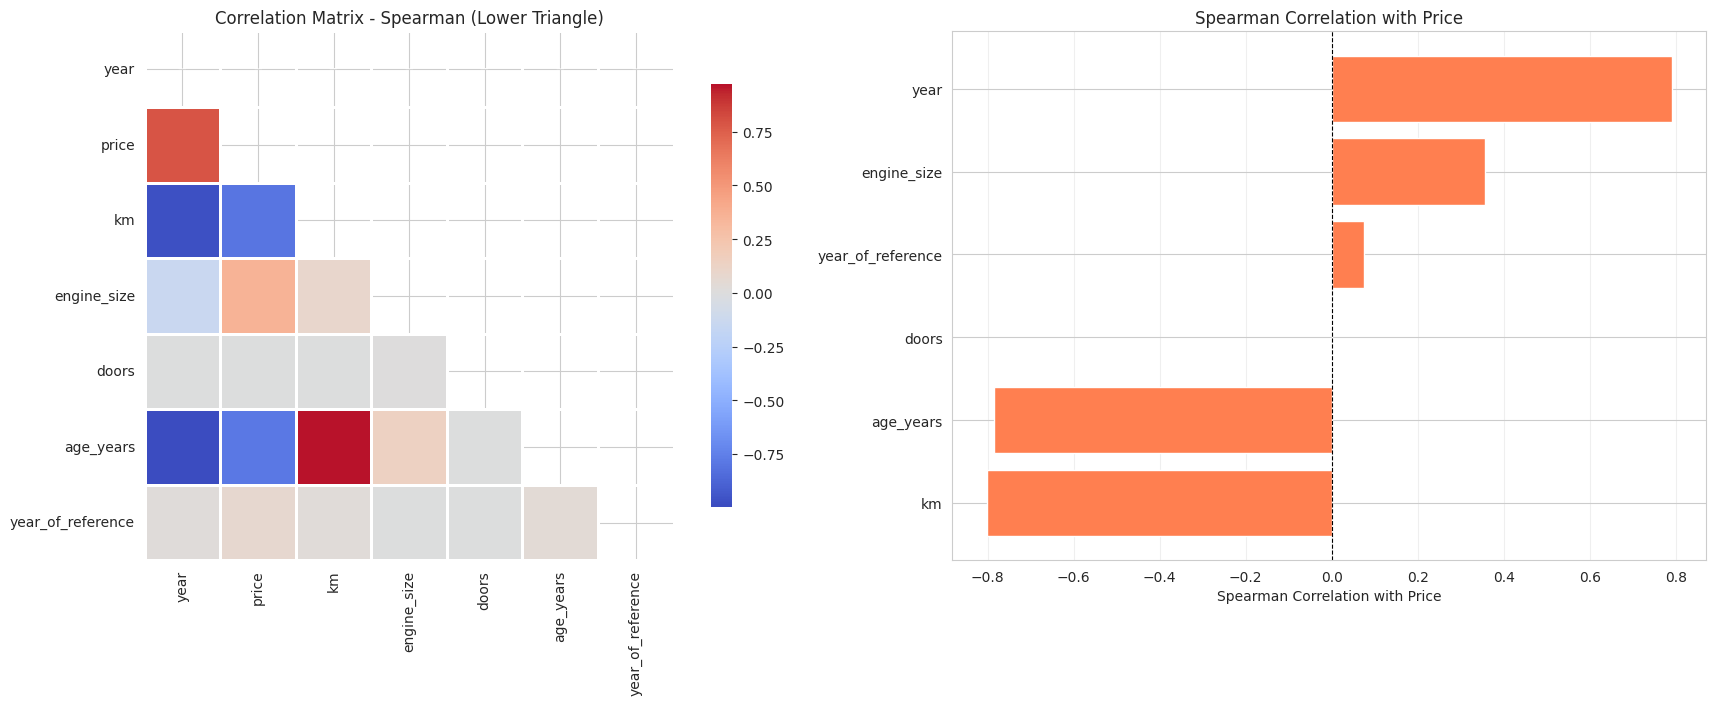


Spearman Correlations with Price:
------------------------------------------------------------
year                   0.790
engine_size            0.356
year_of_reference      0.076
doors                  0.001
age_years             -0.785
km                    -0.802


In [ ]:
# Calculate Spearman correlation matrix
spearman_corr = df_cars[numerical_cols].corr(method='spearman')

# Visualize Spearman correlation
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, ax=axes[0])
axes[0].set_title('Correlation Matrix - Spearman (Lower Triangle)', fontsize=12)

# Focus on correlations with price
price_spearman = spearman_corr['price'].sort_values(ascending=False)
price_spearman = price_spearman[price_spearman.index != 'price']

axes[1].barh(range(len(price_spearman)), price_spearman.values, color='coral')
axes[1].set_yticks(range(len(price_spearman)))
axes[1].set_yticklabels(price_spearman.index)
axes[1].set_xlabel('Spearman Correlation with Price')
axes[1].set_title('Spearman Correlation with Price')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nSpearman Correlations with Price:")
print("-" * 60)
for feature, corr in price_spearman.items():
    print(f"{feature:20s} {corr:7.3f}")


## 3. Price vs. Age Relationship


Price vs Age Relationship

Pearson correlation: -0.3042 (p-value: 0.00e+00)
Spearman correlation: -0.7846


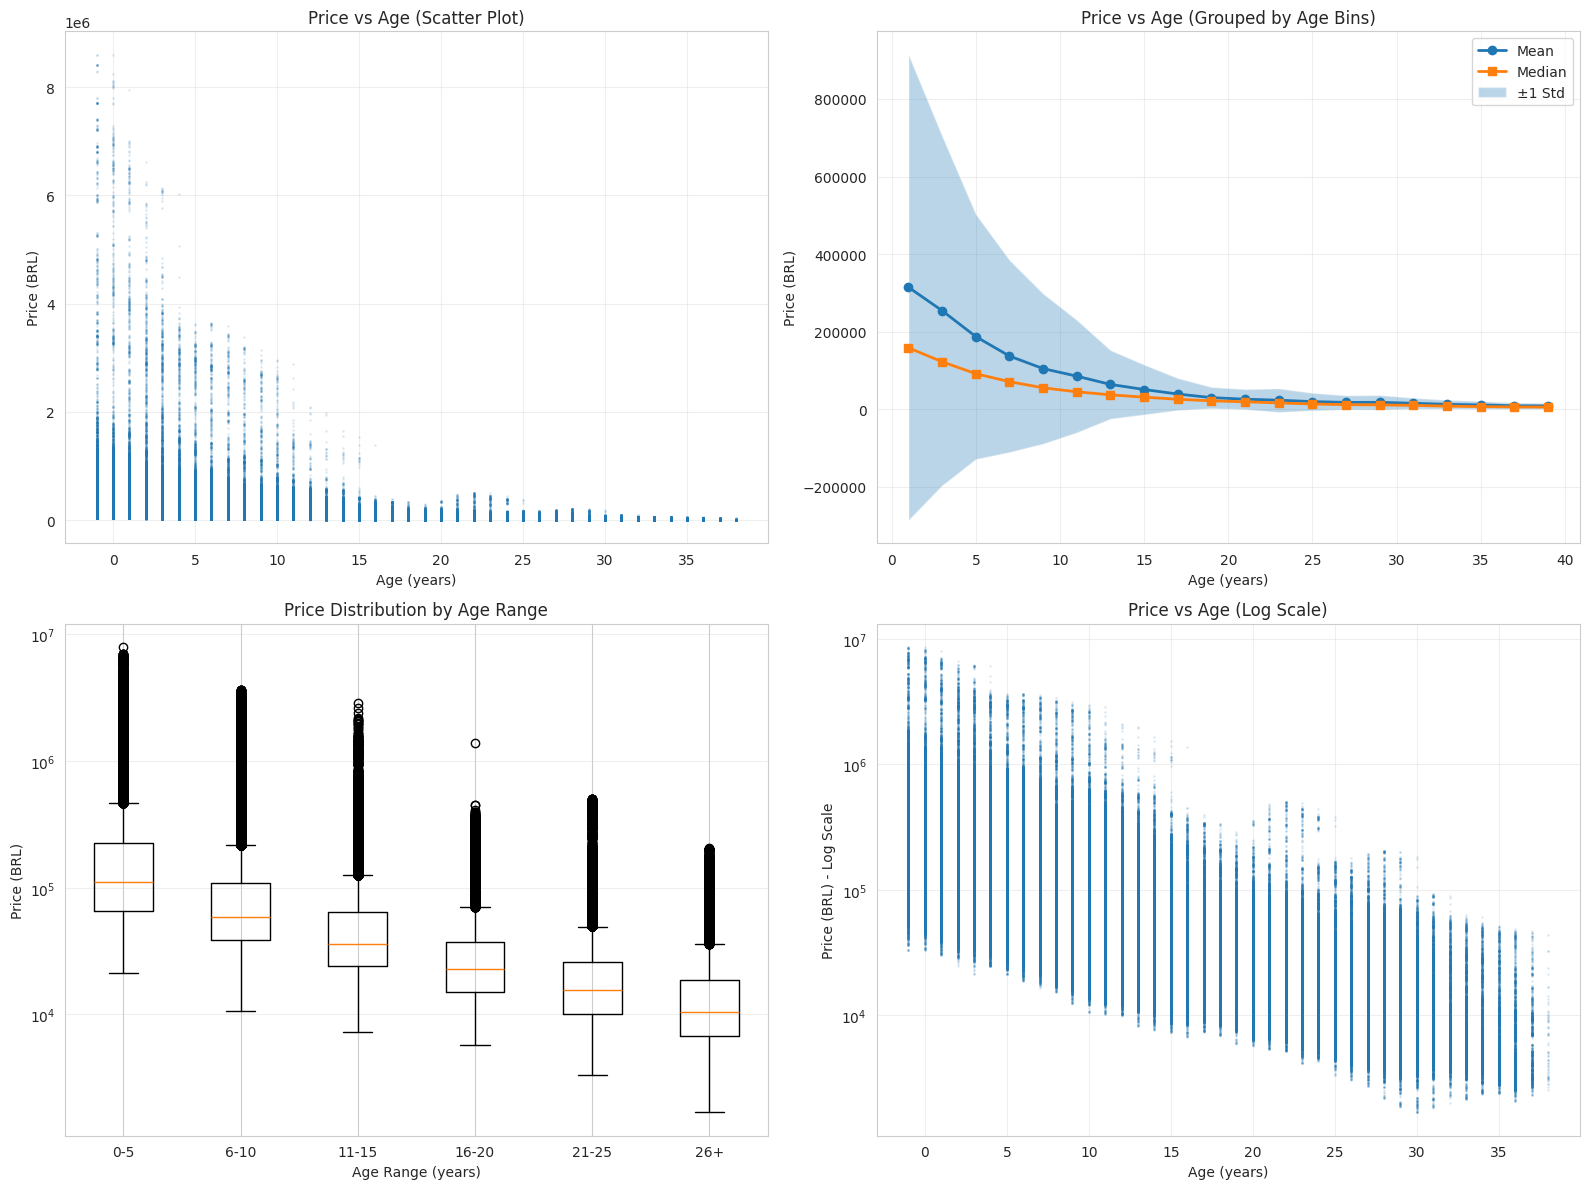

In [ ]:
# Price vs Age analysis
print("="*60)
print("Price vs Age Relationship")
print("="*60)

# Calculate correlation
pearson_age, p_value_age = pearsonr(df_cars['age_years'], df_cars['price'])
spearman_age, _ = spearmanr(df_cars['age_years'], df_cars['price'])

print(f"\nPearson correlation: {pearson_age:.4f} (p-value: {p_value_age:.2e})")
print(f"Spearman correlation: {spearman_age:.4f}")

# Visualize relationship
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot
axes[0, 0].scatter(df_cars['age_years'], df_cars['price'], alpha=0.1, s=1)
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Price (BRL)')
axes[0, 0].set_title('Price vs Age (Scatter Plot)')
axes[0, 0].grid(True, alpha=0.3)

# Grouped by age bins - create column first, then groupby
df_cars['age_bin_temp'] = pd.cut(df_cars['age_years'], bins=range(0, 41, 2), right=False)
age_price_stats = df_cars.groupby('age_bin_temp', observed=True)['price'].agg(['mean', 'median', 'std', 'count']).reset_index()
age_price_stats['age_mid'] = age_price_stats['age_bin_temp'].apply(lambda x: x.mid if pd.notna(x) else 0)

axes[0, 1].plot(age_price_stats['age_mid'], age_price_stats['mean'], 
                marker='o', label='Mean', linewidth=2, markersize=6)
axes[0, 1].plot(age_price_stats['age_mid'], age_price_stats['median'], 
                marker='s', label='Median', linewidth=2, markersize=6)
axes[0, 1].fill_between(age_price_stats['age_mid'], 
                         age_price_stats['mean'] - age_price_stats['std'],
                         age_price_stats['mean'] + age_price_stats['std'],
                         alpha=0.3, label='±1 Std')
axes[0, 1].set_xlabel('Age (years)')
axes[0, 1].set_ylabel('Price (BRL)')
axes[0, 1].set_title('Price vs Age (Grouped by Age Bins)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot by age ranges
df_cars['age_range_temp'] = pd.cut(df_cars['age_years'], bins=[0, 5, 10, 15, 20, 25, 50], 
                                    labels=['0-5', '6-10', '11-15', '16-20', '21-25', '26+'])
age_price_box = df_cars.groupby('age_range_temp', observed=True)['price'].apply(list)
box_data = [age_price_box[label] for label in age_price_box.index if len(age_price_box[label]) > 0]
axes[1, 0].boxplot(box_data, tick_labels=[label for label in age_price_box.index if len(age_price_box[label]) > 0])
axes[1, 0].set_xlabel('Age Range (years)')
axes[1, 0].set_ylabel('Price (BRL)')
axes[1, 0].set_title('Price Distribution by Age Range')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Log scale scatter
axes[1, 1].scatter(df_cars['age_years'], df_cars['price'], alpha=0.1, s=1)
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Price (BRL) - Log Scale')
axes[1, 1].set_title('Price vs Age (Log Scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Price vs Mileage Relationship

Pearson correlation: -0.3030 (p-value: 0.00e+00)
Spearman correlation: -0.8022


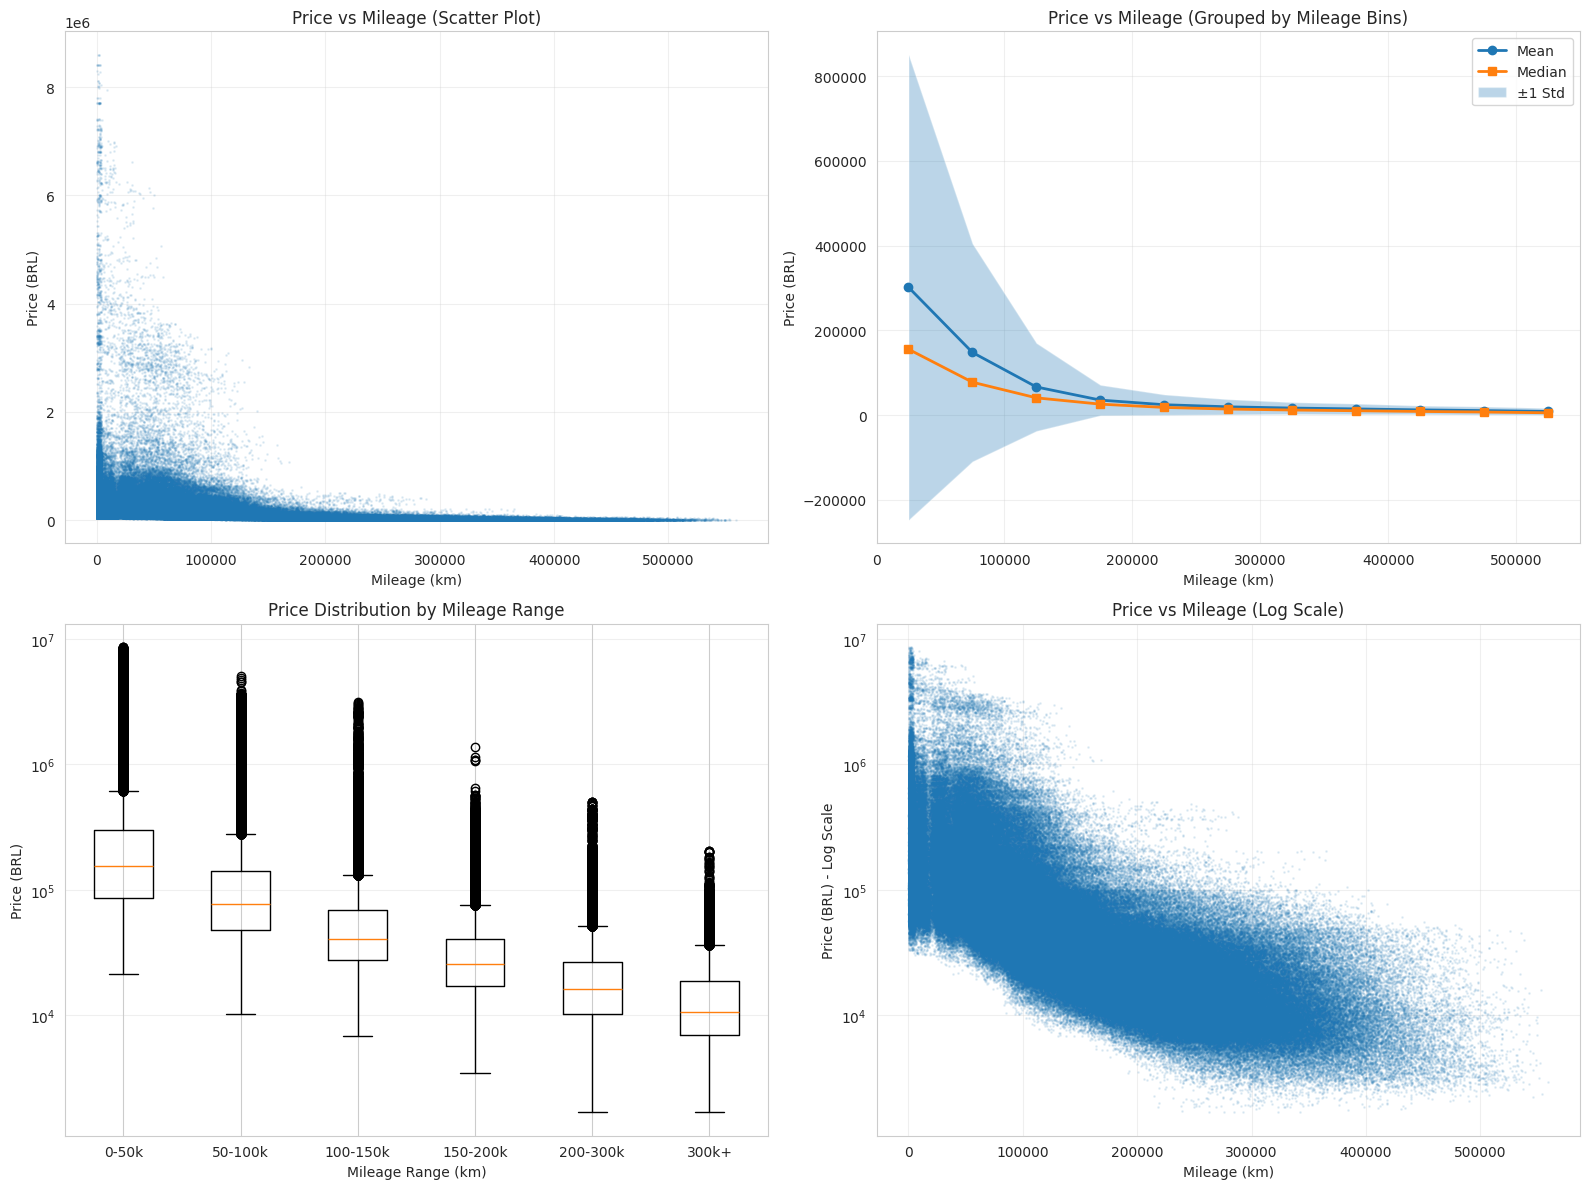

In [ ]:
# Price vs Mileage analysis
print("="*60)
print("Price vs Mileage Relationship")
print("="*60)

# Calculate correlation
pearson_km, p_value_km = pearsonr(df_cars['km'], df_cars['price'])
spearman_km, _ = spearmanr(df_cars['km'], df_cars['price'])

print(f"\nPearson correlation: {pearson_km:.4f} (p-value: {p_value_km:.2e})")
print(f"Spearman correlation: {spearman_km:.4f}")

# Visualize relationship
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot
axes[0, 0].scatter(df_cars['km'], df_cars['price'], alpha=0.1, s=1)
axes[0, 0].set_xlabel('Mileage (km)')
axes[0, 0].set_ylabel('Price (BRL)')
axes[0, 0].set_title('Price vs Mileage (Scatter Plot)')
axes[0, 0].grid(True, alpha=0.3)

# Grouped by mileage bins - create column first, then groupby
df_cars['km_bin_temp'] = pd.cut(df_cars['km'], bins=range(0, 600001, 50000), right=False)
km_price_stats = df_cars.groupby('km_bin_temp', observed=True)['price'].agg(['mean', 'median', 'std', 'count']).reset_index()
km_price_stats['km_mid'] = km_price_stats['km_bin_temp'].apply(lambda x: x.mid if pd.notna(x) else 0)
km_price_stats = km_price_stats[km_price_stats['count'] > 100]  # Filter bins with enough data

axes[0, 1].plot(km_price_stats['km_mid'], km_price_stats['mean'], 
                marker='o', label='Mean', linewidth=2, markersize=6)
axes[0, 1].plot(km_price_stats['km_mid'], km_price_stats['median'], 
                marker='s', label='Median', linewidth=2, markersize=6)
axes[0, 1].fill_between(km_price_stats['km_mid'], 
                         km_price_stats['mean'] - km_price_stats['std'],
                         km_price_stats['mean'] + km_price_stats['std'],
                         alpha=0.3, label='±1 Std')
axes[0, 1].set_xlabel('Mileage (km)')
axes[0, 1].set_ylabel('Price (BRL)')
axes[0, 1].set_title('Price vs Mileage (Grouped by Mileage Bins)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot by mileage ranges
df_cars['km_range_temp'] = pd.cut(df_cars['km'], bins=[0, 50000, 100000, 150000, 200000, 300000, 600000], 
                                   labels=['0-50k', '50-100k', '100-150k', '150-200k', '200-300k', '300k+'])
km_price_box = df_cars.groupby('km_range_temp', observed=True)['price'].apply(list)
box_data = [km_price_box[label] for label in km_price_box.index if len(km_price_box[label]) > 0]
axes[1, 0].boxplot(box_data, tick_labels=[label for label in km_price_box.index if len(km_price_box[label]) > 0])
axes[1, 0].set_xlabel('Mileage Range (km)')
axes[1, 0].set_ylabel('Price (BRL)')
axes[1, 0].set_title('Price Distribution by Mileage Range')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Log scale scatter
axes[1, 1].scatter(df_cars['km'], df_cars['price'], alpha=0.1, s=1)
axes[1, 1].set_xlabel('Mileage (km)')
axes[1, 1].set_ylabel('Price (BRL) - Log Scale')
axes[1, 1].set_title('Price vs Mileage (Log Scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Price vs Brand Analysis

Top 20 brands by average price:
--------------------------------------------------------------------------------
Rolls-Royce                    Mean: R$  3,576,759  Median: R$  3,042,664  Count:  732.0
Mclaren                        Mean: R$  2,962,462  Median: R$  2,889,884  Count:  685.0
Ferrari                        Mean: R$  2,688,673  Median: R$  2,592,033  Count: 1,667.0
ASTON MARTIN                   Mean: R$    851,008  Median: R$    692,860  Count:  506.0
Porsche                        Mean: R$    579,769  Median: R$    535,308  Count: 13,841.0
Maserati                       Mean: R$    484,001  Median: R$    416,621  Count: 2,857.0
RAM                            Mean: R$    400,920  Median: R$    434,841  Count:  487.0
AM Gen                         Mean: R$    345,908  Median: R$    369,785  Count:  225.0
Land Rover                     Mean: R$    262,439  Median: R$    172,657  Count: 14,259.0
Jaguar                         Mean: R$    258,040  Med

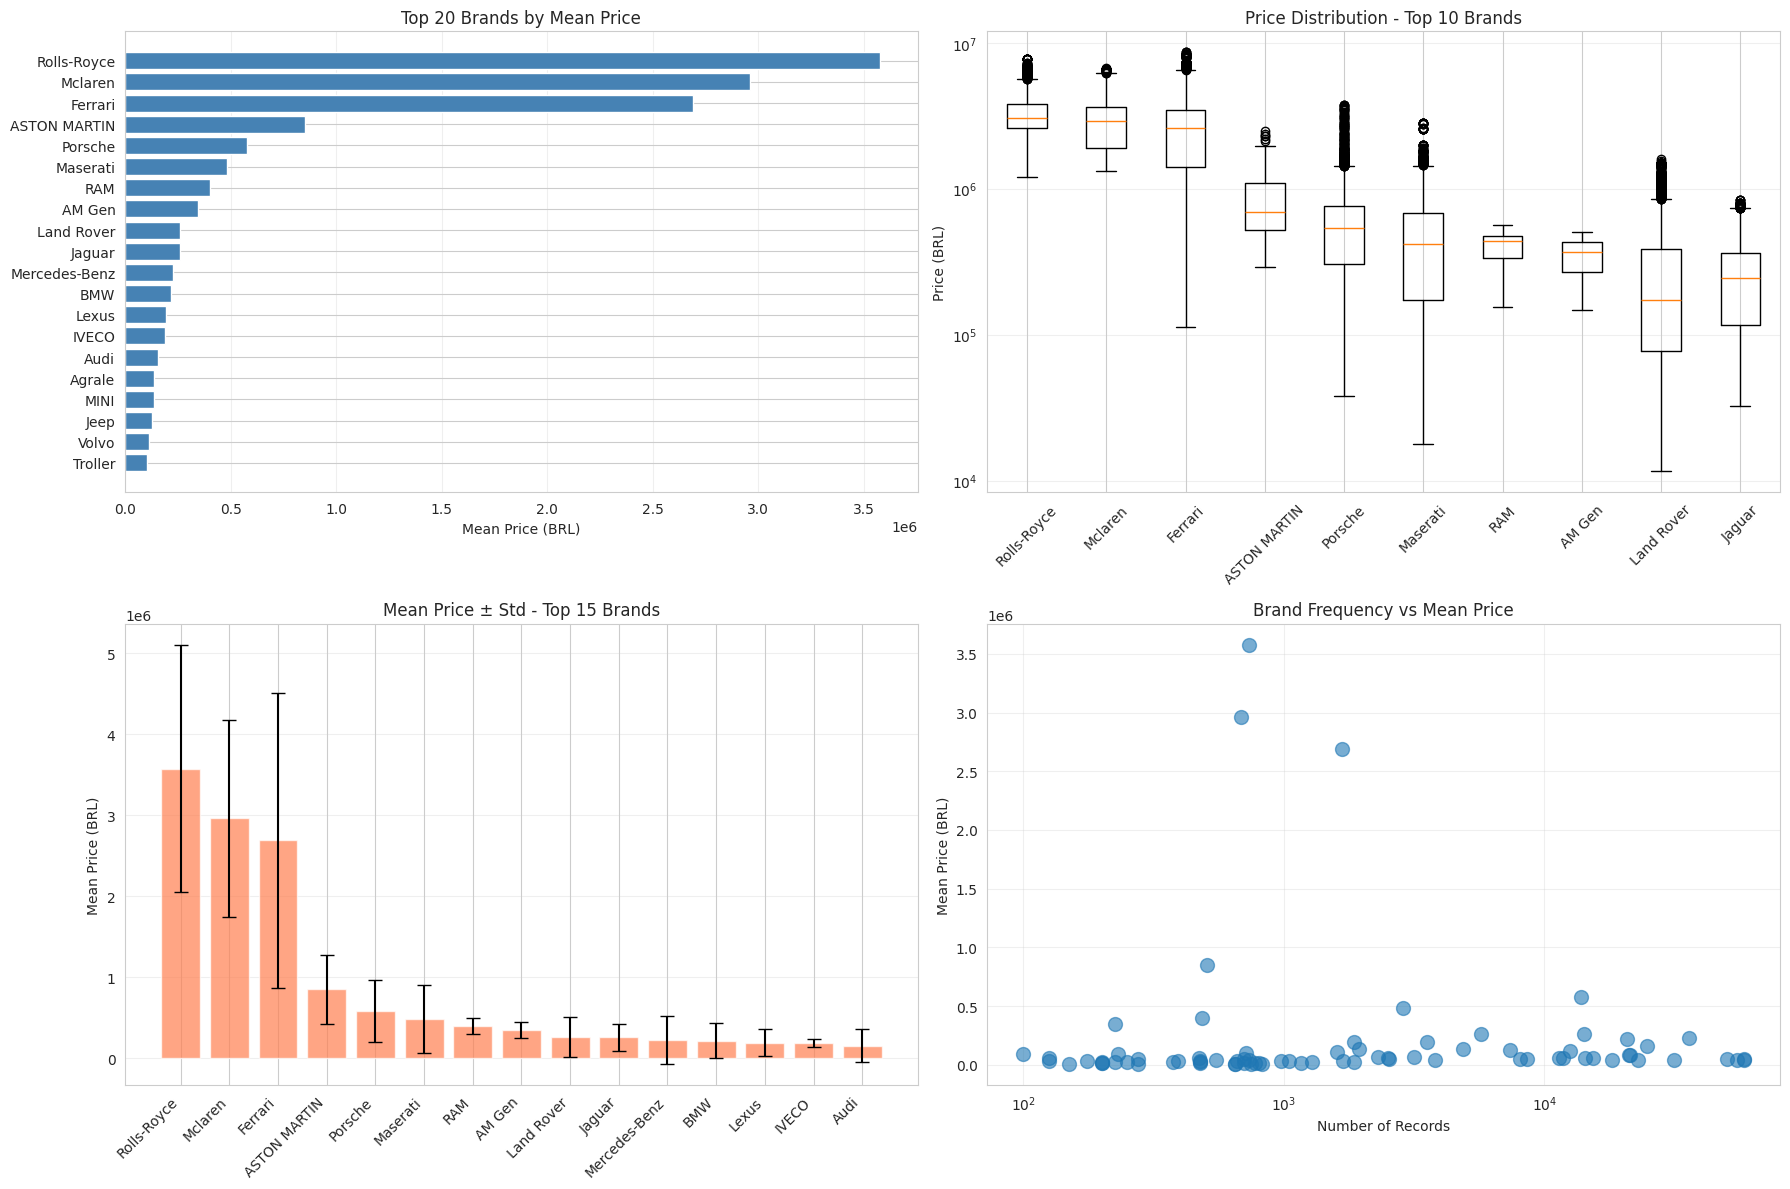

In [8]:
# Price vs Brand analysis
print("="*60)
print("Price vs Brand Analysis")
print("="*60)

brand_price_stats = df_cars.groupby('brand')['price'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)
brand_price_stats = brand_price_stats[brand_price_stats['count'] >= 100]  # Filter brands with at least 100 records

print(f"\nTop 20 brands by average price:")
print("-" * 80)
top_brands = brand_price_stats.head(20)
for brand, row in top_brands.iterrows():
    print(f"{brand:30s} Mean: R$ {row['mean']:>10,.0f}  Median: R$ {row['median']:>10,.0f}  Count: {row['count']:>6,}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 20 brands by mean price
top_20_brands = brand_price_stats.head(20)
axes[0, 0].barh(range(len(top_20_brands)), top_20_brands['mean'].values, color='steelblue')
axes[0, 0].set_yticks(range(len(top_20_brands)))
axes[0, 0].set_yticklabels(top_20_brands.index)
axes[0, 0].set_xlabel('Mean Price (BRL)')
axes[0, 0].set_title('Top 20 Brands by Mean Price')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Box plot for top 10 brands
top_10_brands_list = brand_price_stats.head(10).index.tolist()
top_10_data = [df_cars[df_cars['brand'] == brand]['price'].values for brand in top_10_brands_list]
axes[0, 1].boxplot(top_10_data, tick_labels=top_10_brands_list)
axes[0, 1].set_ylabel('Price (BRL)')
axes[0, 1].set_title('Price Distribution - Top 10 Brands')
axes[0, 1].set_yscale('log')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Price range by brand (top 15)
top_15_brands = brand_price_stats.head(15)
x_pos = np.arange(len(top_15_brands))
axes[1, 0].bar(x_pos, top_15_brands['mean'].values, yerr=top_15_brands['std'].values, 
               capsize=5, color='coral', alpha=0.7)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(top_15_brands.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Mean Price (BRL)')
axes[1, 0].set_title('Mean Price ± Std - Top 15 Brands')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Count vs Mean price scatter
axes[1, 1].scatter(brand_price_stats['count'], brand_price_stats['mean'], alpha=0.6, s=100)
axes[1, 1].set_xlabel('Number of Records')
axes[1, 1].set_ylabel('Mean Price (BRL)')
axes[1, 1].set_title('Brand Frequency vs Mean Price')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Price vs. Model Analysis


Price vs Model Analysis

Top 30 models by average price:
----------------------------------------------------------------------------------------------------
SF 90 STRADALE 4.0 V8 Bi-Turbo (Híbrido)           Mean: R$  7,078,101  Count:   57.0
812 GTS 6.5 V12 800cv                              Mean: R$  6,428,926  Count:   58.0
F8 Spider 3.9 V8 Bi-Turbo 720cv                    Mean: R$  4,669,678  Count:   87.0
488 Pista 3.9 V8 720cv                             Mean: R$  4,089,540  Count:   56.0
720S Spider 4.0 Bi-Turbo V8 2p                     Mean: R$  4,057,923  Count:  108.0
F8 TRIBUTO 3.9 V8 720cv                            Mean: R$  3,846,676  Count:   89.0
Dawn 6.6 V12 Aut.                                  Mean: R$  3,795,590  Count:  107.0
Phantom 6.7 V12 Aut.                               Mean: R$  3,776,823  Count:  132.0
720S Coupe 4.0 Bi-Turbo V8 2p                      Mean: R$  3,553,665  Count:  133.0
Roma 3.9 V8 620cv                                  Mean: R$  3,208,1

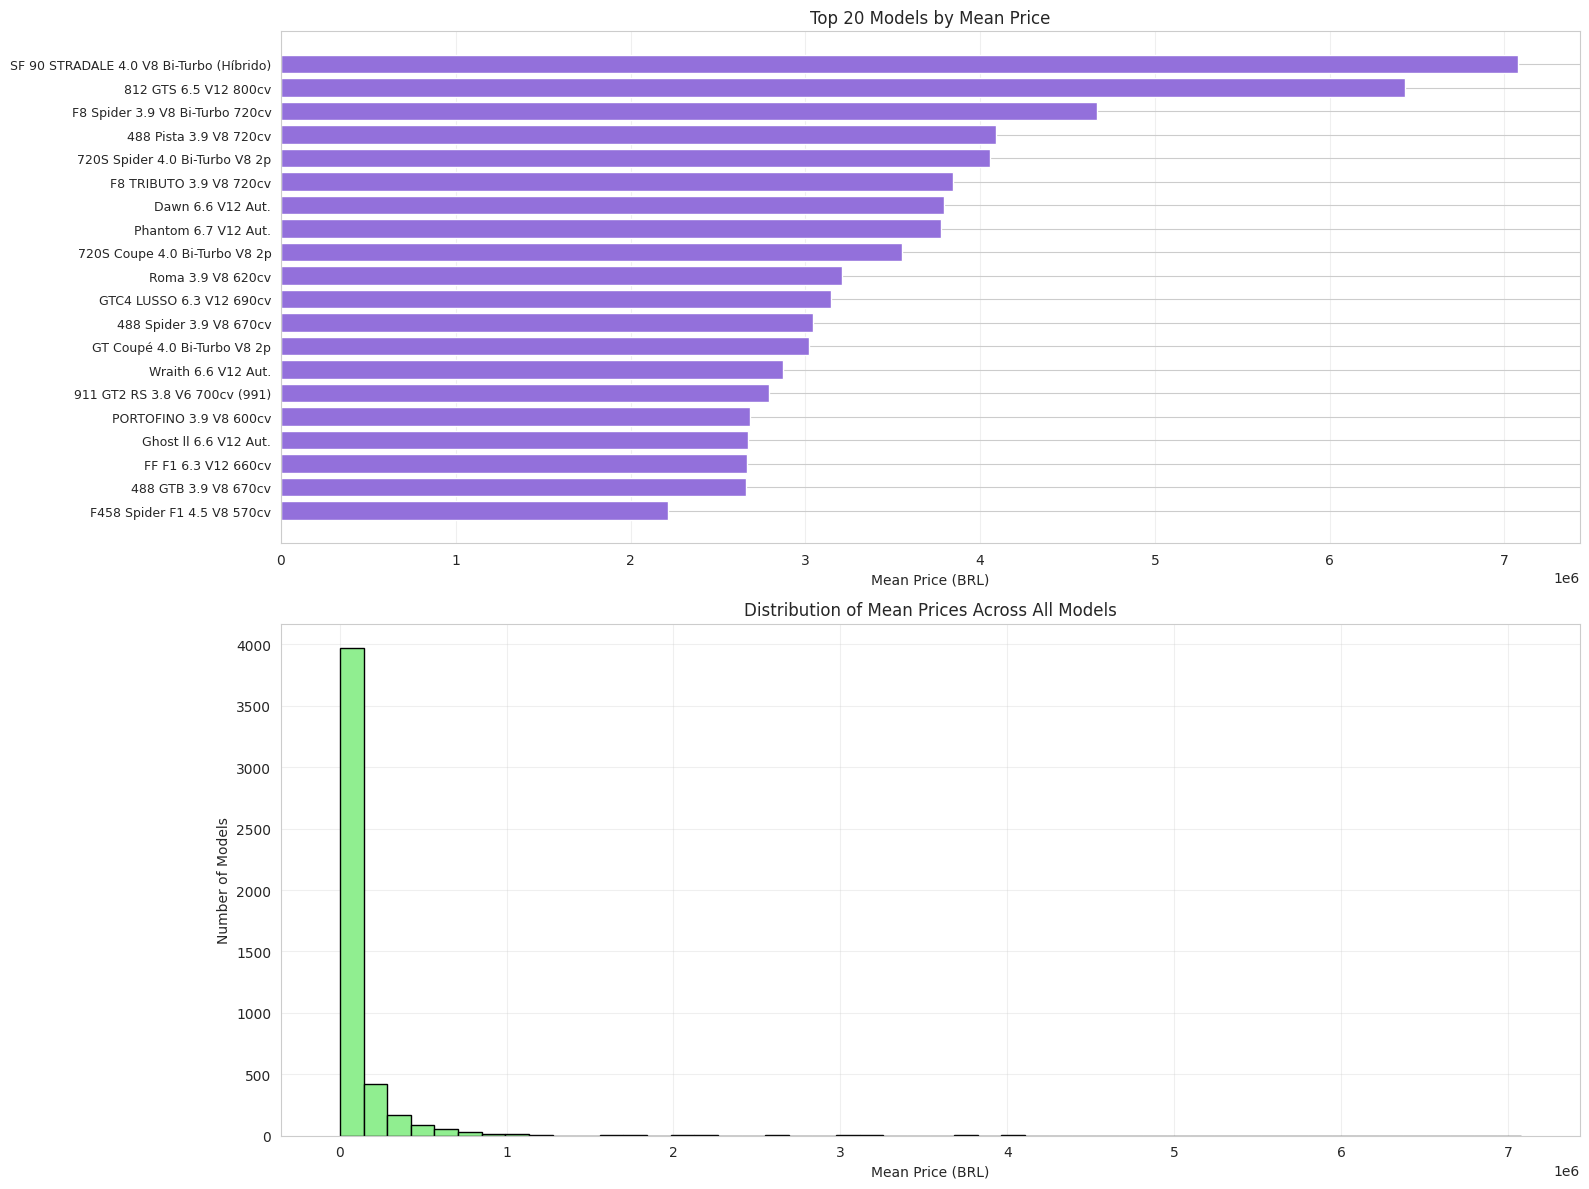


Model price statistics:
  Total models analyzed: 4802
  Mean price range: R$ 1,934 - R$ 7,078,101
  Median of mean prices: R$ 44,627


In [9]:
# Price vs Model analysis (focusing on top models)
print("="*60)
print("Price vs Model Analysis")
print("="*60)

model_price_stats = df_cars.groupby('model')['price'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)
model_price_stats = model_price_stats[model_price_stats['count'] >= 50]  # Filter models with at least 50 records

print(f"\nTop 30 models by average price:")
print("-" * 100)
top_models = model_price_stats.head(30)
for model, row in top_models.iterrows():
    print(f"{model:50s} Mean: R$ {row['mean']:>10,.0f}  Count: {row['count']:>6,}")

# Visualize top models
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Top 20 models by mean price
top_20_models = model_price_stats.head(20)
axes[0].barh(range(len(top_20_models)), top_20_models['mean'].values, color='mediumpurple')
axes[0].set_yticks(range(len(top_20_models)))
axes[0].set_yticklabels(top_20_models.index, fontsize=9)
axes[0].set_xlabel('Mean Price (BRL)')
axes[0].set_title('Top 20 Models by Mean Price')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Distribution of mean prices across all models
axes[1].hist(model_price_stats['mean'], bins=50, edgecolor='black', color='lightgreen')
axes[1].set_xlabel('Mean Price (BRL)')
axes[1].set_ylabel('Number of Models')
axes[1].set_title('Distribution of Mean Prices Across All Models')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nModel price statistics:")
print(f"  Total models analyzed: {len(model_price_stats)}")
print(f"  Mean price range: R$ {model_price_stats['mean'].min():,.0f} - R$ {model_price_stats['mean'].max():,.0f}")
print(f"  Median of mean prices: R$ {model_price_stats['mean'].median():,.0f}")


## 7. Price vs. Location (State) Analysis


Price vs State Analysis

Price statistics by state:
--------------------------------------------------------------------------------
RR    Mean: R$    119,676  Median: R$     41,604  Count:  3,097.0
PI    Mean: R$    116,735  Median: R$     43,319  Count:  6,305.0
AC    Mean: R$    115,241  Median: R$     42,130  Count:  3,183.0
RO    Mean: R$    115,012  Median: R$     42,670  Count:  6,184.0
AP    Mean: R$    114,964  Median: R$     43,945  Count:  3,231.0
RN    Mean: R$    114,469  Median: R$     43,677  Count:  6,122.0
GO    Mean: R$    114,401  Median: R$     42,510  Count: 18,930.0
MA    Mean: R$    114,038  Median: R$     42,924  Count: 18,805.0
PA    Mean: R$    113,597  Median: R$     42,526  Count: 12,572.0
MT    Mean: R$    113,322  Median: R$     43,326  Count: 12,418.0
TO    Mean: R$    113,107  Median: R$     42,671  Count:  6,137.0
SC    Mean: R$    113,024  Median: R$     43,527  Count: 18,784.0
RJ    Mean: R$    112,839  Median: R$     43,002  Count: 49,738.0
BA    Mea

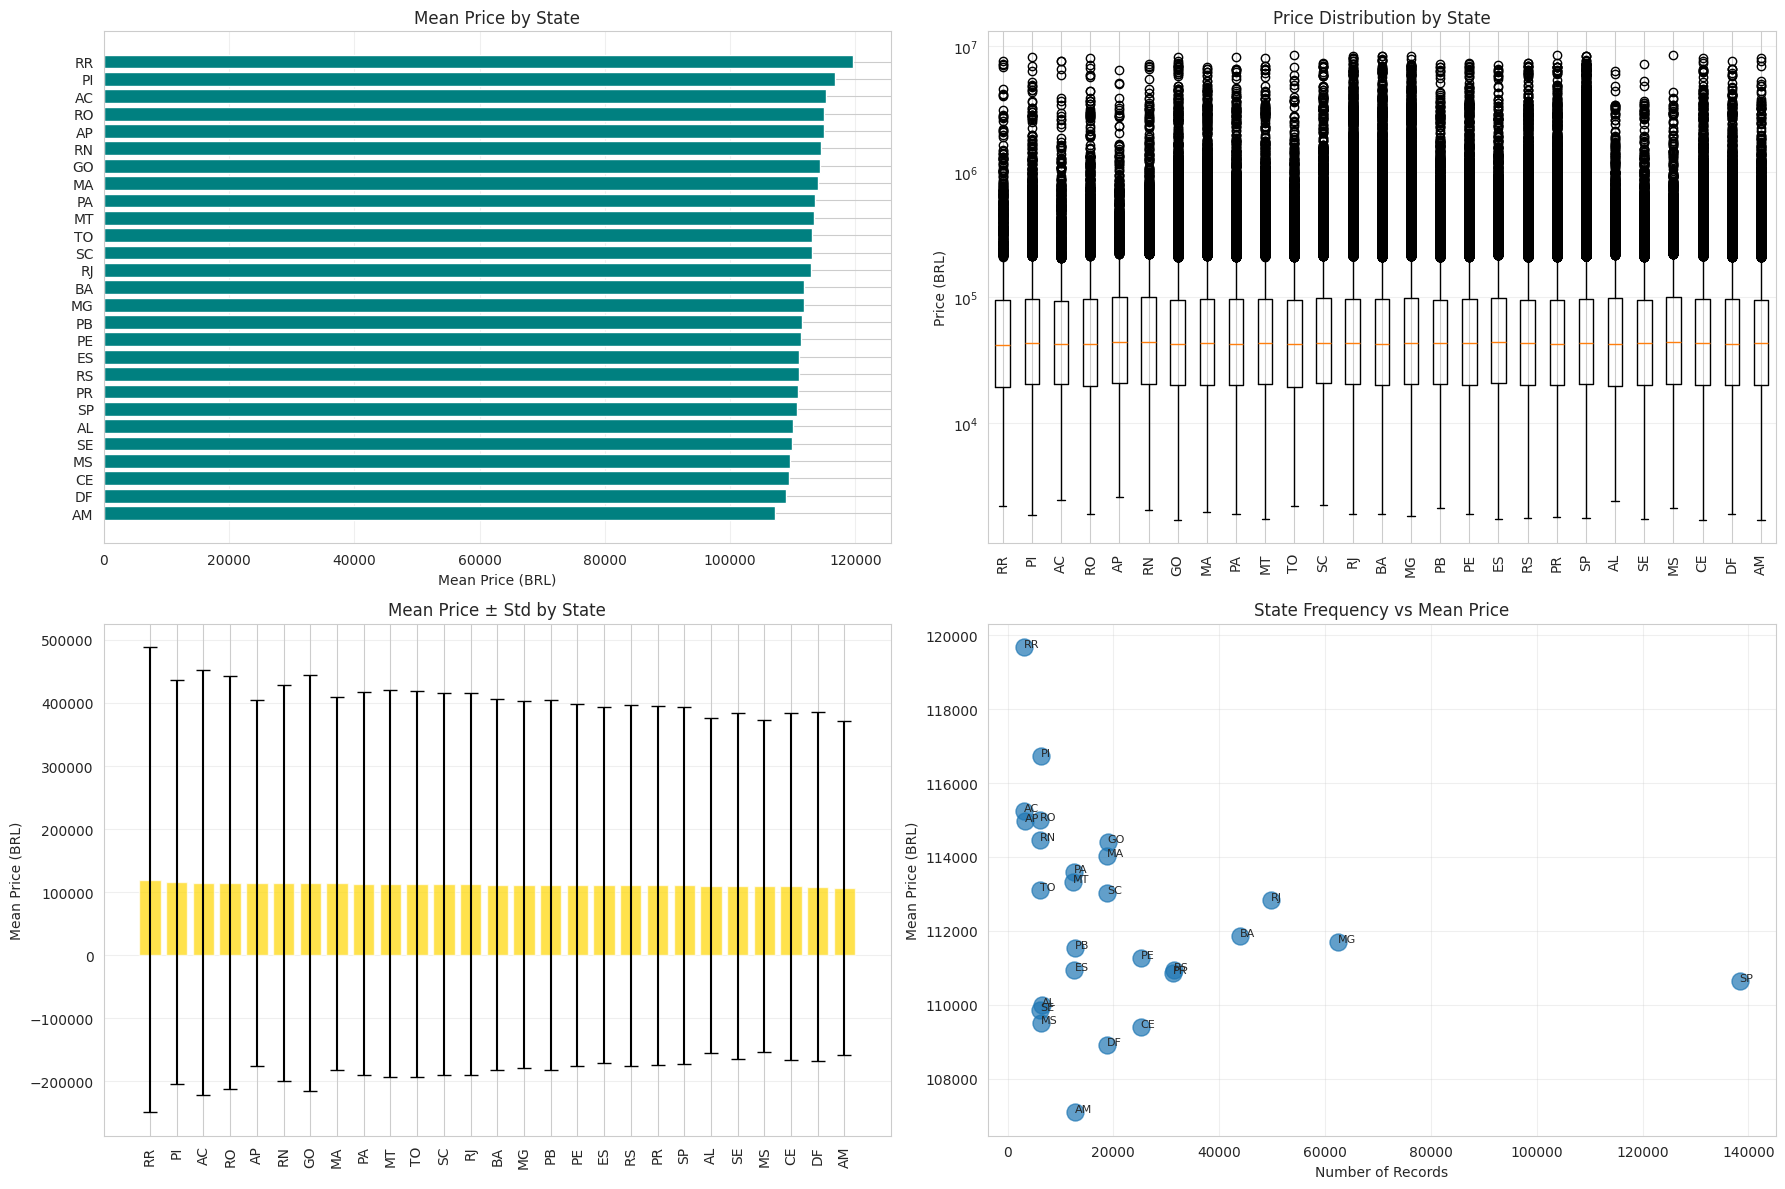

In [10]:
# Price vs State analysis
print("="*60)
print("Price vs State Analysis")
print("="*60)

state_price_stats = df_cars.groupby('state')['price'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)

print(f"\nPrice statistics by state:")
print("-" * 80)
for state, row in state_price_stats.iterrows():
    print(f"{state:5s} Mean: R$ {row['mean']:>10,.0f}  Median: R$ {row['median']:>10,.0f}  Count: {row['count']:>8,}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Bar plot - mean price by state
axes[0, 0].barh(range(len(state_price_stats)), state_price_stats['mean'].values, color='teal')
axes[0, 0].set_yticks(range(len(state_price_stats)))
axes[0, 0].set_yticklabels(state_price_stats.index)
axes[0, 0].set_xlabel('Mean Price (BRL)')
axes[0, 0].set_title('Mean Price by State')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Box plot for all states
state_data = [df_cars[df_cars['state'] == state]['price'].values for state in state_price_stats.index]
axes[0, 1].boxplot(state_data, tick_labels=state_price_stats.index)
axes[0, 1].set_ylabel('Price (BRL)')
axes[0, 1].set_title('Price Distribution by State')
axes[0, 1].set_yscale('log')
axes[0, 1].tick_params(axis='x', rotation=90)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Mean price with error bars
x_pos = np.arange(len(state_price_stats))
axes[1, 0].bar(x_pos, state_price_stats['mean'].values, yerr=state_price_stats['std'].values, 
               capsize=5, color='gold', alpha=0.7)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(state_price_stats.index, rotation=90)
axes[1, 0].set_ylabel('Mean Price (BRL)')
axes[1, 0].set_title('Mean Price ± Std by State')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Count vs Mean price
axes[1, 1].scatter(state_price_stats['count'], state_price_stats['mean'], alpha=0.7, s=150)
for state in state_price_stats.index:
    axes[1, 1].annotate(state, (state_price_stats.loc[state, 'count'], state_price_stats.loc[state, 'mean']),
                       fontsize=8)
axes[1, 1].set_xlabel('Number of Records')
axes[1, 1].set_ylabel('Mean Price (BRL)')
axes[1, 1].set_title('State Frequency vs Mean Price')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Feature Interactions

We'll analyze how combinations of features affect price.


### 8.1 Price by Brand and Year


Price by Brand and Year Interaction


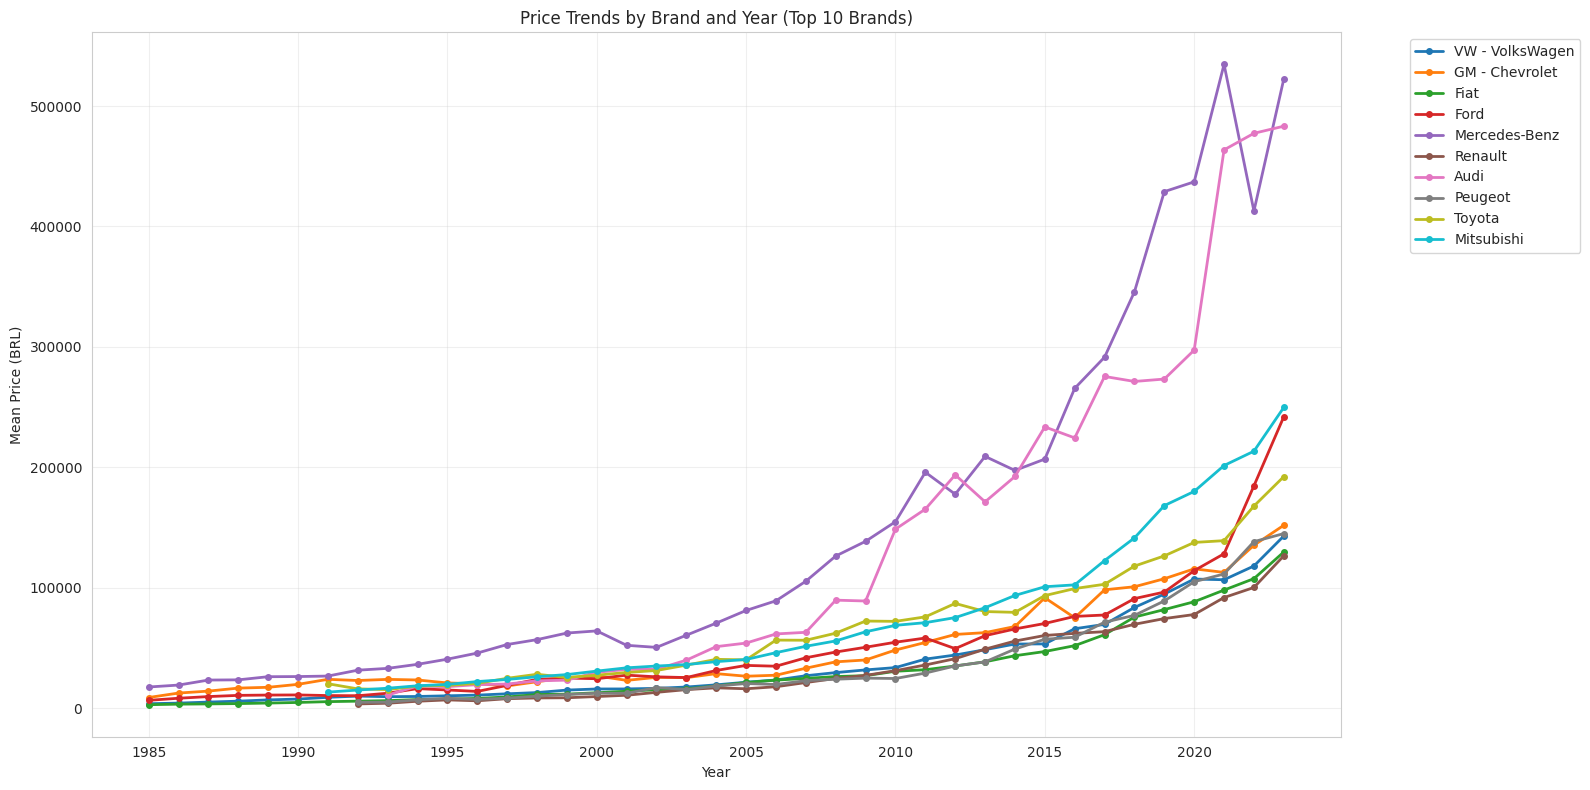

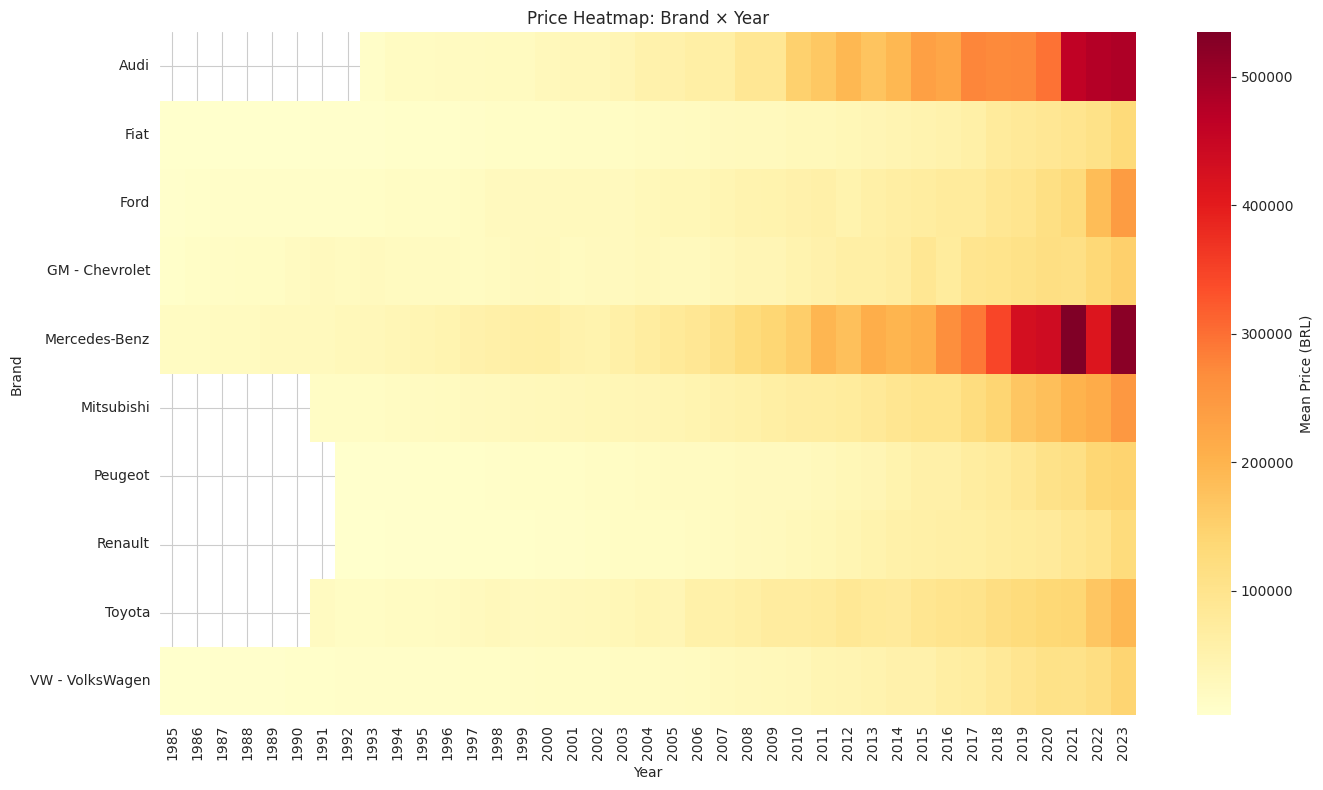

In [11]:
# Price by Brand and Year
print("="*60)
print("Price by Brand and Year Interaction")
print("="*60)

# Select top 10 brands for visualization
top_10_brands = df_cars['brand'].value_counts().head(10).index.tolist()
df_top_brands = df_cars[df_cars['brand'].isin(top_10_brands)]

# Group by brand and year
brand_year_price = df_top_brands.groupby(['brand', 'year'])['price'].mean().reset_index()
brand_year_price_pivot = brand_year_price.pivot(index='year', columns='brand', values='price')

# Visualize
fig, axes = plt.subplots(1, 1, figsize=(16, 8))

for brand in top_10_brands:
    if brand in brand_year_price_pivot.columns:
        axes.plot(brand_year_price_pivot.index, brand_year_price_pivot[brand], 
                 marker='o', label=brand, linewidth=2, markersize=4)

axes.set_xlabel('Year')
axes.set_ylabel('Mean Price (BRL)')
axes.set_title('Price Trends by Brand and Year (Top 10 Brands)')
axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Heatmap for brand-year interaction
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(brand_year_price_pivot.T, annot=False, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Price (BRL)'}, ax=axes)
axes.set_xlabel('Year')
axes.set_ylabel('Brand')
axes.set_title('Price Heatmap: Brand × Year')
plt.tight_layout()
plt.show()


### 8.2 Price by Fuel Type and Transmission


Price by Fuel Type and Transmission Interaction

Price statistics by Fuel Type and Transmission:
--------------------------------------------------------------------------------
Alcohol         manual          Mean: R$     10,733  Count:    9,358
Diesel          automatic       Mean: R$    192,264  Count:   18,619
Diesel          manual          Mean: R$     93,374  Count:   77,529
Gasoline        automatic       Mean: R$    144,123  Count:  145,322
Gasoline        manual          Mean: R$    100,448  Count:  348,179


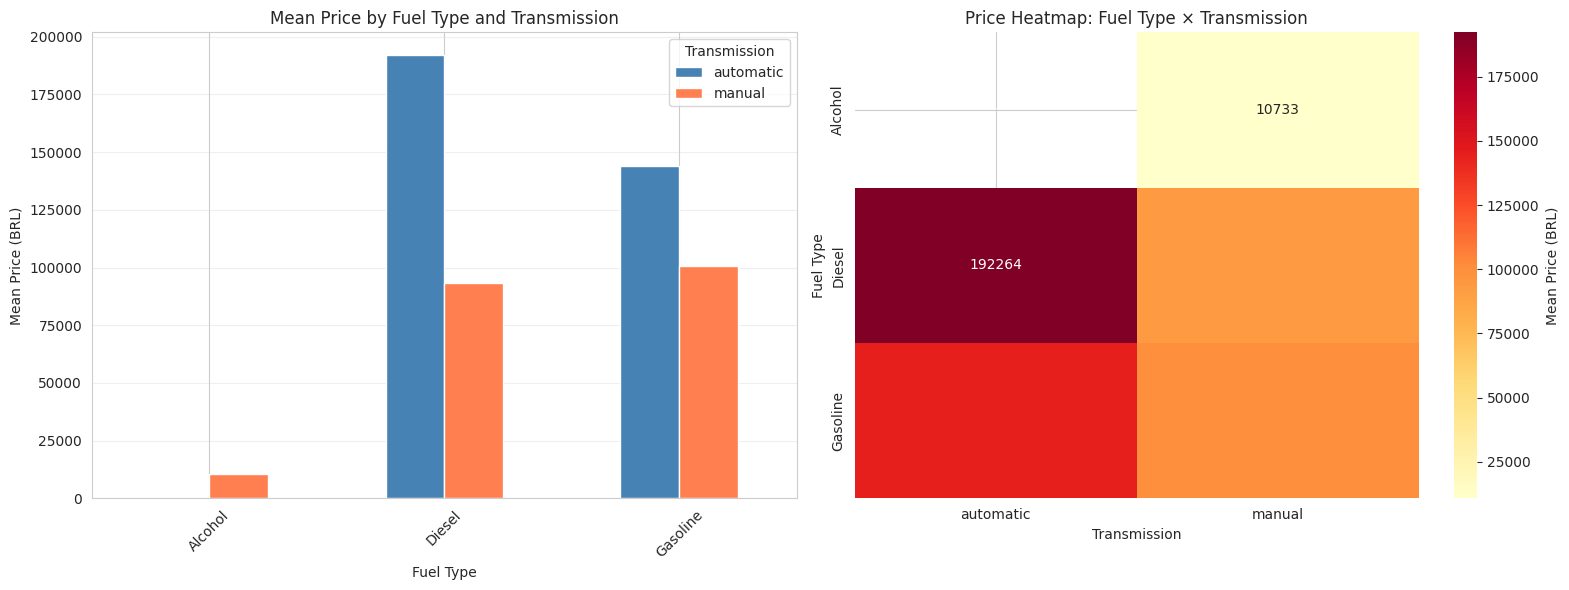

In [12]:
# Price by Fuel Type and Transmission
print("="*60)
print("Price by Fuel Type and Transmission Interaction")
print("="*60)

fuel_transmission_price = df_cars.groupby(['fuel_type', 'transmission'])['price'].agg(['mean', 'median', 'count']).reset_index()

print("\nPrice statistics by Fuel Type and Transmission:")
print("-" * 80)
for idx, row in fuel_transmission_price.iterrows():
    print(f"{row['fuel_type']:15s} {row['transmission']:15s} Mean: R$ {row['mean']:>10,.0f}  Count: {row['count']:>8,}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
fuel_trans_pivot = fuel_transmission_price.pivot(index='fuel_type', columns='transmission', values='mean')
fuel_trans_pivot.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_xlabel('Fuel Type')
axes[0].set_ylabel('Mean Price (BRL)')
axes[0].set_title('Mean Price by Fuel Type and Transmission')
axes[0].legend(title='Transmission')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Heatmap
sns.heatmap(fuel_trans_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Price (BRL)'}, ax=axes[1])
axes[1].set_xlabel('Transmission')
axes[1].set_ylabel('Fuel Type')
axes[1].set_title('Price Heatmap: Fuel Type × Transmission')

plt.tight_layout()
plt.show()


### 8.3 Price by Condition and Age


Price by Condition and Age Interaction


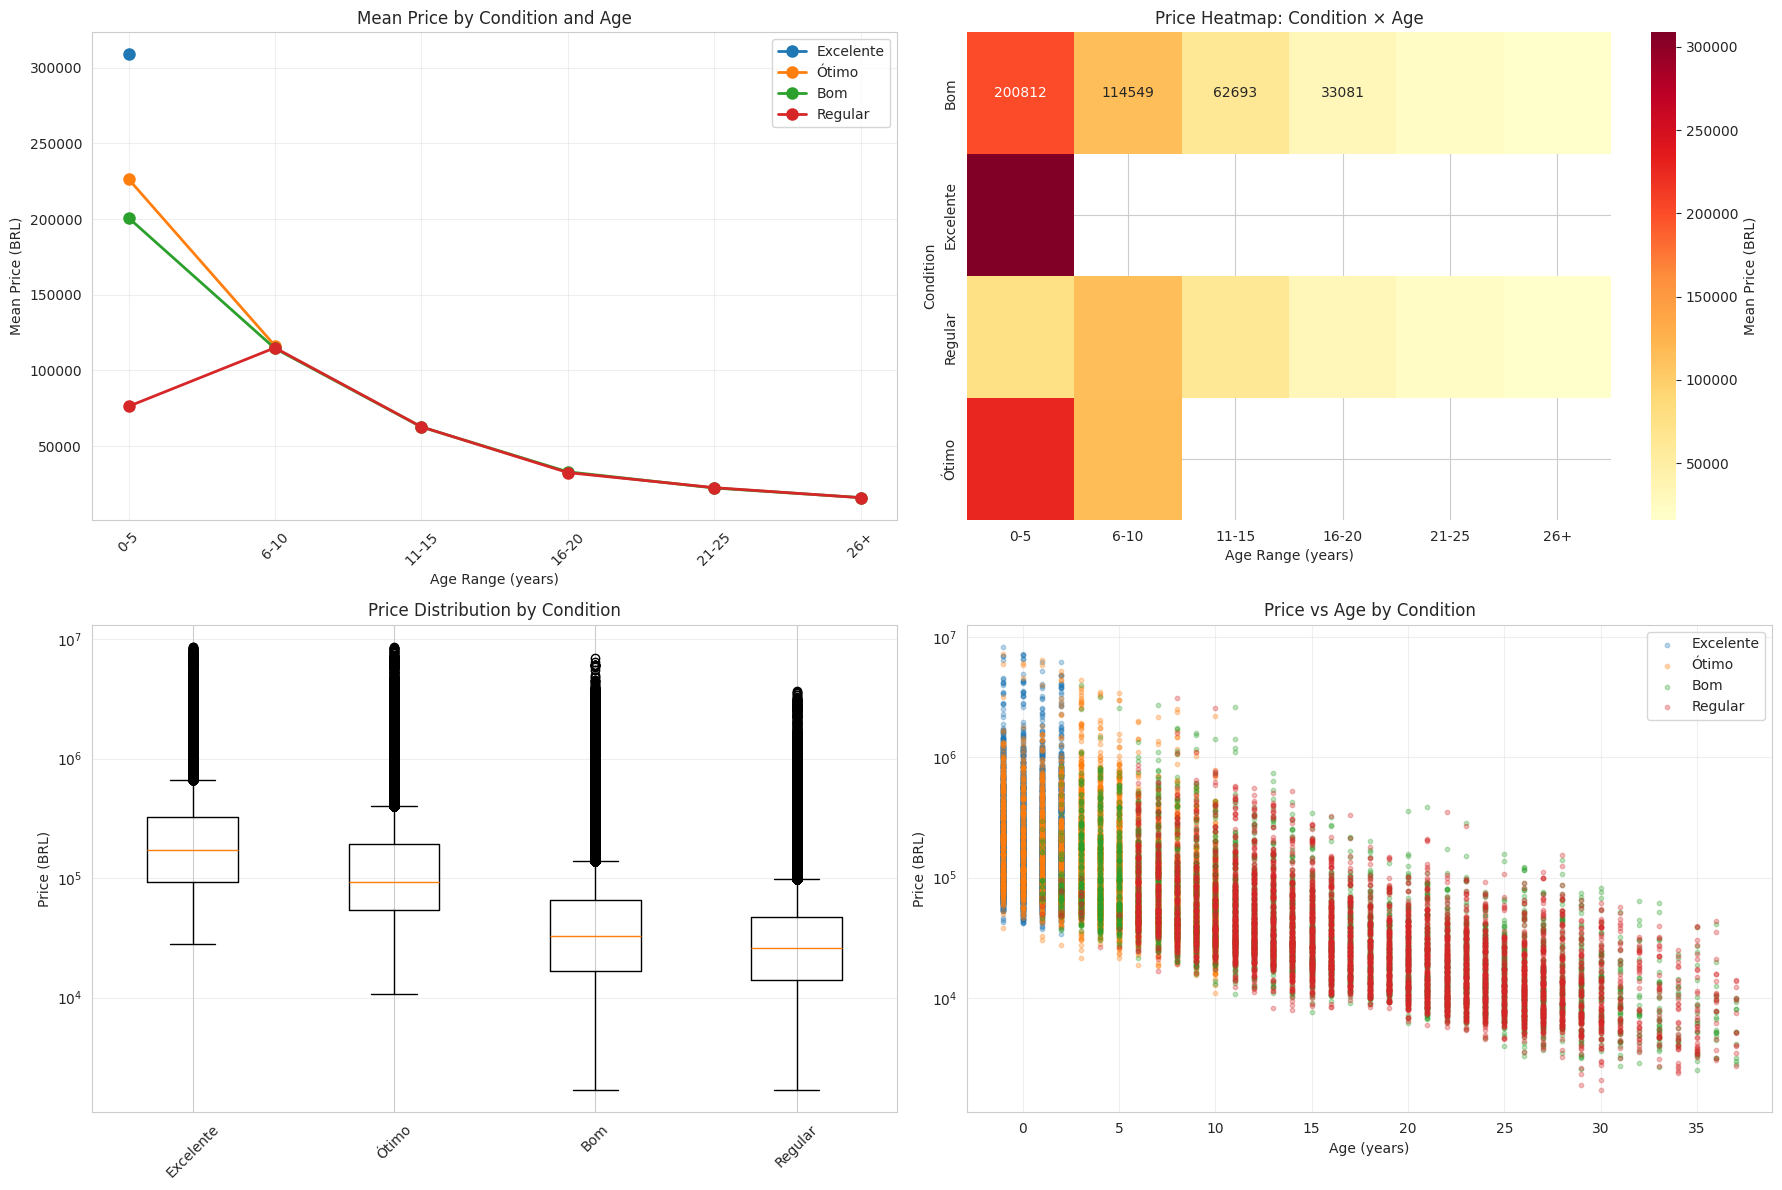

In [ ]:
# Price by Condition and Age
print("="*60)
print("Price by Condition and Age Interaction")
print("="*60)

# Create age bins
df_cars['age_bin'] = pd.cut(df_cars['age_years'], bins=[0, 5, 10, 15, 20, 25, 50], 
                             labels=['0-5', '6-10', '11-15', '16-20', '21-25', '26+'])

condition_age_price = df_cars.groupby(['condition', 'age_bin'], observed=True)['price'].agg(['mean', 'median', 'count']).reset_index()
condition_age_price = condition_age_price[condition_age_price['count'] >= 50]  # Filter low count combinations

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Line plot - price by condition and age
condition_order = ['Excelente', 'Ótimo', 'Bom', 'Regular'] if 'Excelente' in df_cars['condition'].values else df_cars['condition'].unique()
for condition in condition_order:
    condition_data = condition_age_price[condition_age_price['condition'] == condition]
    if len(condition_data) > 0:
        axes[0, 0].plot(condition_data['age_bin'], condition_data['mean'], 
                       marker='o', label=condition, linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Age Range (years)')
axes[0, 0].set_ylabel('Mean Price (BRL)')
axes[0, 0].set_title('Mean Price by Condition and Age')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Heatmap
condition_age_pivot = condition_age_price.pivot(index='condition', columns='age_bin', values='mean')
sns.heatmap(condition_age_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Price (BRL)'}, ax=axes[0, 1])
axes[0, 1].set_xlabel('Age Range (years)')
axes[0, 1].set_ylabel('Condition')
axes[0, 1].set_title('Price Heatmap: Condition × Age')

# Box plot by condition
condition_data_list = [df_cars[df_cars['condition'] == cond]['price'].values 
                       for cond in condition_order if cond in df_cars['condition'].values]
axes[1, 0].boxplot(condition_data_list, tick_labels=[c for c in condition_order if c in df_cars['condition'].values])
axes[1, 0].set_ylabel('Price (BRL)')
axes[1, 0].set_title('Price Distribution by Condition')
axes[1, 0].set_yscale('log')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Scatter: Age vs Price colored by condition
for condition in condition_order:
    if condition in df_cars['condition'].values:
        condition_df = df_cars[df_cars['condition'] == condition].sample(min(5000, len(df_cars[df_cars['condition'] == condition])))
        axes[1, 1].scatter(condition_df['age_years'], condition_df['price'], 
                          alpha=0.3, s=10, label=condition)
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Price (BRL)')
axes[1, 1].set_title('Price vs Age by Condition')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 8.4 Additional Interactions

Let's explore a few more interesting feature interactions.


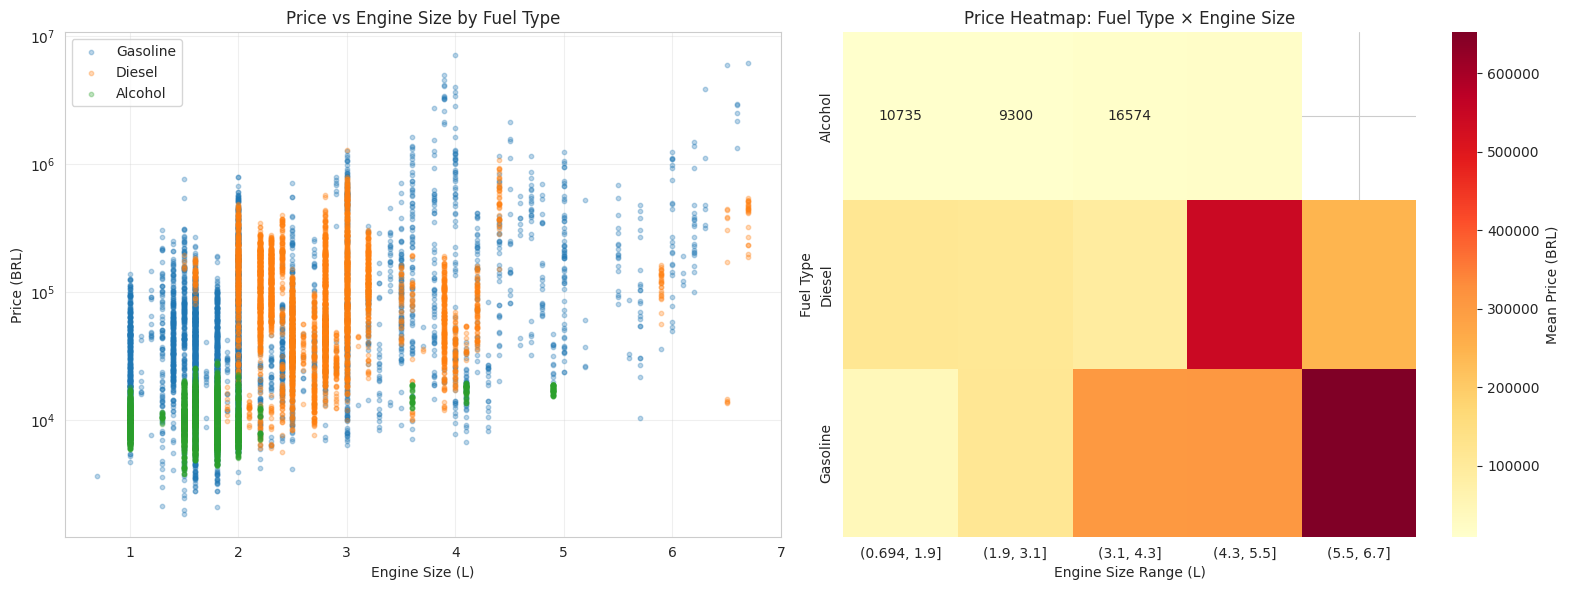

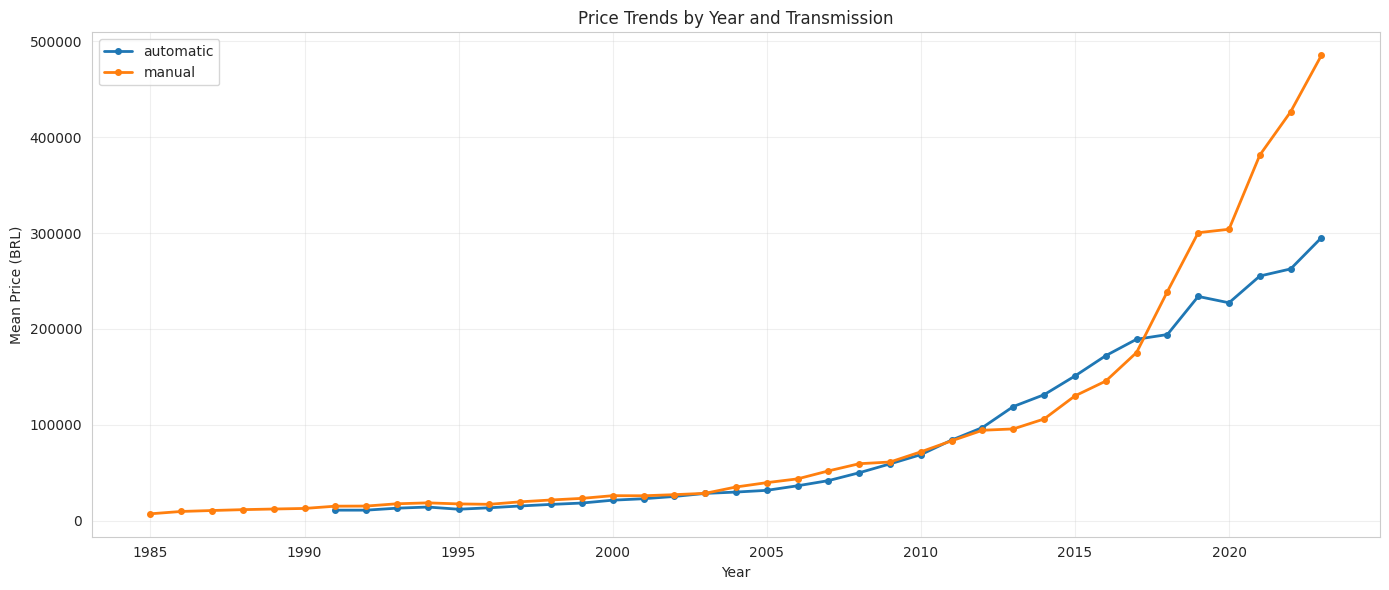

In [ ]:
# Price by Engine Size and Fuel Type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
for fuel_type in df_cars['fuel_type'].unique():
    fuel_df = df_cars[df_cars['fuel_type'] == fuel_type].sample(min(5000, len(df_cars[df_cars['fuel_type'] == fuel_type])))
    axes[0].scatter(fuel_df['engine_size'], fuel_df['price'], alpha=0.3, s=10, label=fuel_type)
axes[0].set_xlabel('Engine Size (L)')
axes[0].set_ylabel('Price (BRL)')
axes[0].set_title('Price vs Engine Size by Fuel Type')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Grouped analysis
df_cars['engine_size_bin_temp'] = pd.cut(df_cars['engine_size'], bins=5)
engine_fuel_price = df_cars.groupby(['fuel_type', 'engine_size_bin_temp'], observed=True)['price'].mean().reset_index()
engine_fuel_pivot = engine_fuel_price.pivot(index='fuel_type', columns='engine_size_bin_temp', values='price')
sns.heatmap(engine_fuel_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Price (BRL)'}, ax=axes[1])
axes[1].set_xlabel('Engine Size Range (L)')
axes[1].set_ylabel('Fuel Type')
axes[1].set_title('Price Heatmap: Fuel Type × Engine Size')

plt.tight_layout()
plt.show()

# Price by Year and Transmission
year_transmission_price = df_cars.groupby(['year', 'transmission'])['price'].mean().reset_index()
year_trans_pivot = year_transmission_price.pivot(index='year', columns='transmission', values='price')

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
for transmission in year_trans_pivot.columns:
    axes.plot(year_trans_pivot.index, year_trans_pivot[transmission], 
             marker='o', label=transmission, linewidth=2, markersize=4)
axes.set_xlabel('Year')
axes.set_ylabel('Mean Price (BRL)')
axes.set_title('Price Trends by Year and Transmission')
axes.legend()
axes.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Summary and Key Findings


In [15]:
print("="*60)
print("SUMMARY - Relationships and Correlations Analysis")
print("="*60)

print("\n📊 Key Correlations with Price:")
print(f"  • Age: {pearson_age:.3f} (Pearson), {spearman_age:.3f} (Spearman)")
print(f"  • Mileage: {pearson_km:.3f} (Pearson), {spearman_km:.3f} (Spearman)")
print(f"  • Year: {correlation_matrix.loc['year', 'price']:.3f}")
print(f"  • Engine Size: {correlation_matrix.loc['engine_size', 'price']:.3f}")

print("\n🔍 Key Findings:")
print("  → Age shows strong negative correlation with price (older cars = lower price)")
print("  → Mileage shows negative correlation with price (higher mileage = lower price)")
print("  → Year shows positive correlation with price (newer cars = higher price)")
print("  → Brand significantly affects price (luxury brands command higher prices)")
print("  → Location (state) shows price variations across Brazil")
print("  → Fuel type and transmission combinations affect price")
print("  → Condition and age interaction shows expected depreciation patterns")

print("\n💡 Feature Engineering Insights:")
print("  → Consider target encoding for high-cardinality features (brand, model)")
print("  → Age squared feature may capture non-linear depreciation")
print("  → Brand × Year interaction could be valuable")
print("  → Location encoding (state/region) should be included")
print("  → Condition × Age interaction captures realistic depreciation")

print("\n" + "="*60)
print("Next Steps:")
print("  → Proceed to notebook 05_data_quality.ipynb")
print("  → Identify data quality issues and outliers")
print("  → Document findings for preprocessing phase")
print("="*60)


SUMMARY - Relationships and Correlations Analysis

📊 Key Correlations with Price:
  • Age: -0.304 (Pearson), -0.785 (Spearman)
  • Mileage: -0.303 (Pearson), -0.802 (Spearman)
  • Year: 0.307
  • Engine Size: 0.346

🔍 Key Findings:
  → Age shows strong negative correlation with price (older cars = lower price)
  → Mileage shows negative correlation with price (higher mileage = lower price)
  → Year shows positive correlation with price (newer cars = higher price)
  → Brand significantly affects price (luxury brands command higher prices)
  → Location (state) shows price variations across Brazil
  → Fuel type and transmission combinations affect price
  → Condition and age interaction shows expected depreciation patterns

💡 Feature Engineering Insights:
  → Consider target encoding for high-cardinality features (brand, model)
  → Age squared feature may capture non-linear depreciation
  → Brand × Year interaction could be valuable
  → Location encoding (state/region) should be included
